Lab Assignment 3: Phoneme Segmentation and Voicing Analysis in Speech


Objective 1

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Install required libraries
!pip install librosa soundfile matplotlib numpy scipy noisereduce

#Import libraries
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import soundfile as sf
import noisereduce as nr

Sampling Rate: 16000
Signal Length: 117120
Preprocessed file saved as: preprocessed_speech.wav


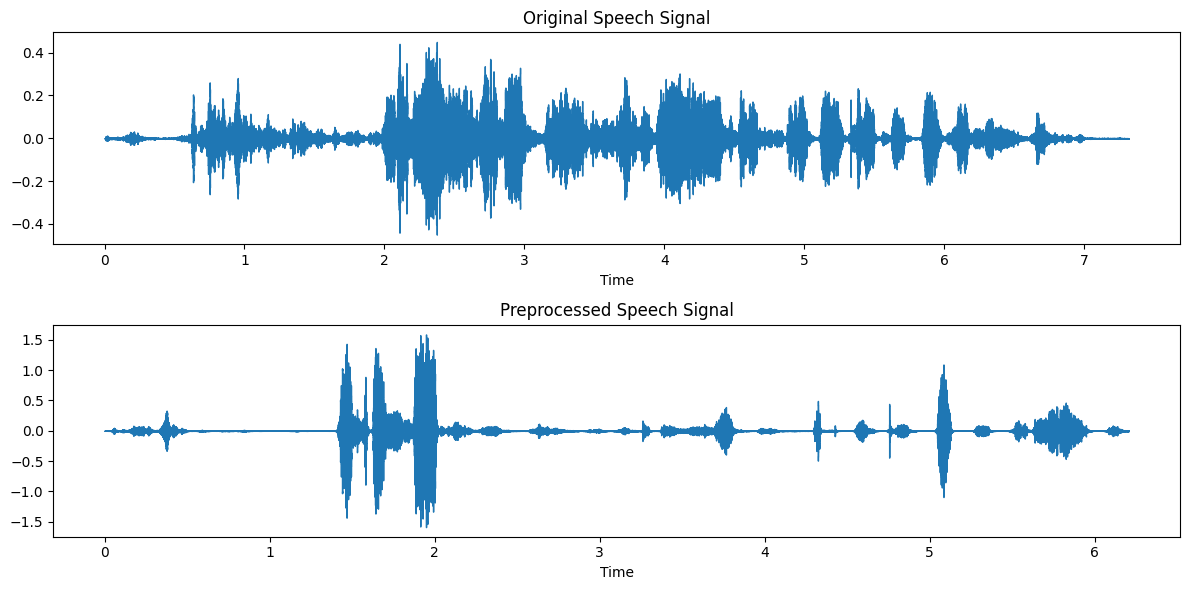

In [4]:
#1. Load and preprocess the recorded speech signal.
audio_path = "/content/drive/MyDrive/Colab Notebooks/Speech Processing/Lab3/record.wav"
signal, sr = librosa.load(audio_path, sr=16000)

print("Sampling Rate:", sr)
print("Signal Length:", len(signal))

if signal.ndim > 1:
    signal = np.mean(signal, axis=1)

denoised_signal = nr.reduce_noise(y=signal, sr=sr)

normalized_signal = denoised_signal / np.max(np.abs(denoised_signal))

trimmed_signal, _ = librosa.effects.trim(
    normalized_signal,
    top_db=20
)

pre_emphasis = 0.97
preprocessed_signal = np.append(
    trimmed_signal[0],
    trimmed_signal[1:] - pre_emphasis * trimmed_signal[:-1]
)

sf.write("/content/drive/MyDrive/Colab Notebooks/Speech Processing/Lab3/preprocessed_speech.wav", preprocessed_signal, sr)
print("Preprocessed file saved as: preprocessed_speech.wav")

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
librosa.display.waveshow(signal, sr=sr)
plt.title("Original Speech Signal")
plt.subplot(2,1,2)
librosa.display.waveshow(preprocessed_signal, sr=sr)
plt.title("Preprocessed Speech Signal")
plt.tight_layout()
plt.show()


2. Automatically segment the speech into phoneme-level units.


In [21]:
!pip install transformers torchaudio
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC

audio_path = "/content/drive/MyDrive/Colab Notebooks/Speech Processing/Lab3/preprocessed_speech.wav"
speech, sr = librosa.load(audio_path, sr=16000)

print("Sampling Rate:", sr)
print("Audio Duration (sec):", len(speech)/sr)

processor = Wav2Vec2Processor.from_pretrained(
    "facebook/wav2vec2-base-960h"
)
model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-base-960h"
)

inputs = processor(
    speech,
    sampling_rate=16000,
    return_tensors="pt"
)

with torch.no_grad():
    logits = model(inputs.input_values).logits

predicted_ids = torch.argmax(logits, dim=-1)
tokens = processor.batch_decode(predicted_ids)

print("\nRecognized Phoneme/Character Sequence:\n")
print(tokens[0])

num_frames = logits.shape[1]
audio_duration = len(speech) / sr
time_per_frame = audio_duration / num_frames

ids = predicted_ids[0].tolist()
segments = []

prev_id = ids[0]
start_frame = 0

for i in range(1, len(ids)):
    if ids[i] != prev_id:
        phoneme = processor.tokenizer.decode([prev_id])
        start_time = start_frame * time_per_frame
        end_time = i * time_per_frame
        duration = end_time - start_time

        segments.append((phoneme, start_time, end_time, duration))

        prev_id = ids[i]
        start_frame = i

phoneme = processor.tokenizer.decode([prev_id])
start_time = start_frame * time_per_frame
end_time = num_frames * time_per_frame
duration = end_time - start_time
segments.append((phoneme, start_time, end_time, duration))

print("\nPHONEME-LEVEL SEGMENTATION WITH CONTINUATION\n")
print("Phoneme | Start(s) | End(s) | Duration(s)")
print("-------------------------------------------")

for p, s, e, d in segments:
    if p.strip() != "":
        print(f"{p:6s} | {s:7.3f} | {e:7.3f} | {d:7.3f}")

with open("phoneme_segments.txt", "w") as f:
    for p, s, e, d in segments:
        if p.strip() != "":
            f.write(f"{p},{s:.3f},{e:.3f},{d:.3f}\n")

print("\nSaved to phoneme_segments.txt")

Sampling Rate: 16000
Audio Duration (sec): 6.208


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Recognized Phoneme/Character Sequence:

SHE CERCHED I BU HER A BUDIENOBOD ANQUITT PUDIOUS

PHONEME-LEVEL SEGMENTATION WITH CONTINUATION

Phoneme | Start(s) | End(s) | Duration(s)
-------------------------------------------
S      |   1.442 |   1.462 |   0.020
H      |   1.462 |   1.502 |   0.040
E      |   1.522 |   1.542 |   0.020
C      |   1.642 |   1.662 |   0.020
E      |   1.742 |   1.762 |   0.020
R      |   1.762 |   1.782 |   0.020
C      |   1.862 |   1.882 |   0.020
H      |   1.902 |   1.922 |   0.020
E      |   1.922 |   1.943 |   0.020
D      |   1.943 |   1.963 |   0.020
I      |   2.143 |   2.163 |   0.020
B      |   2.263 |   2.283 |   0.020
U      |   2.343 |   2.363 |   0.020
H      |   2.543 |   2.563 |   0.020
E      |   2.623 |   2.643 |   0.020
R      |   2.683 |   2.703 |   0.020
A      |   2.984 |   3.004 |   0.020
B      |   3.104 |   3.124 |   0.020
U      |   3.164 |   3.184 |   0.020
D      |   3.244 |   3.264 |   0.020
I      |   3.304 |   3.324 |   0.020

3. Plot the time-domain waveform corresponding to each extracted phoneme.


Total phoneme segments: 41


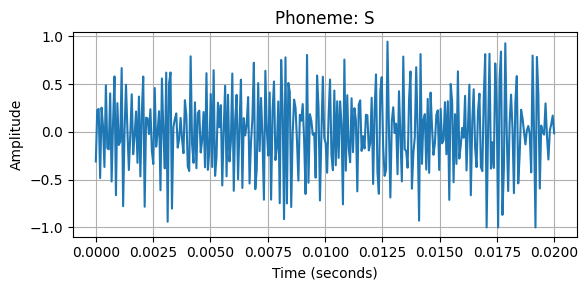

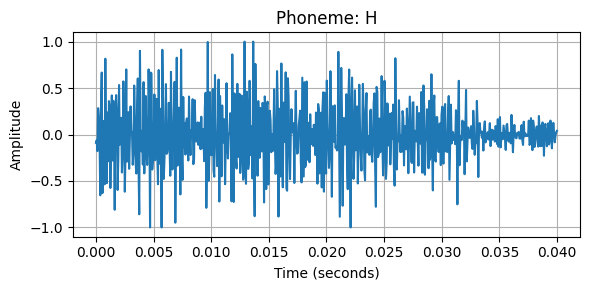

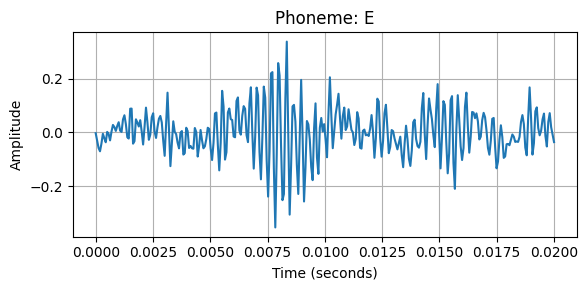

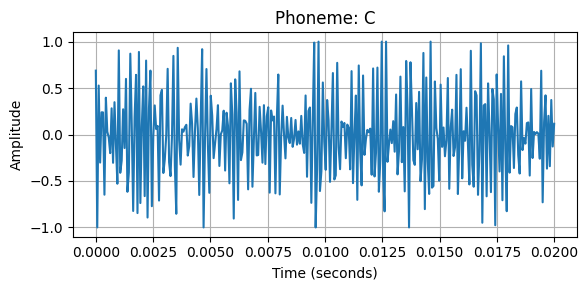

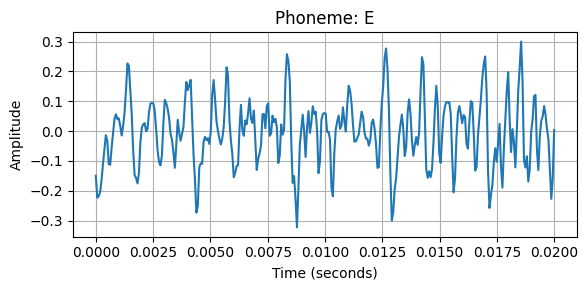

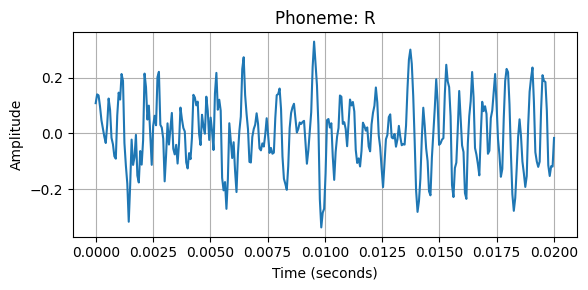

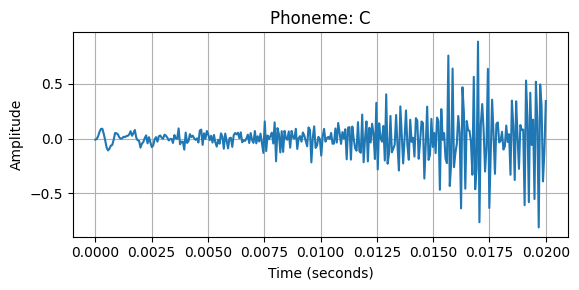

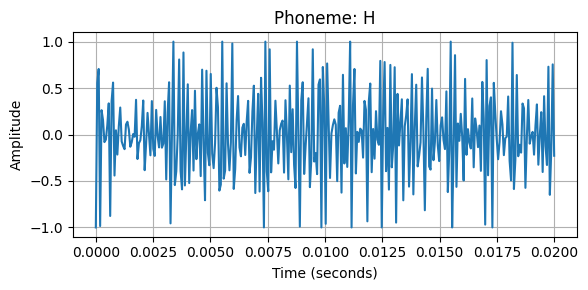

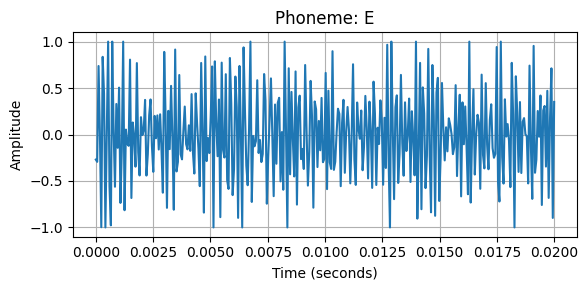

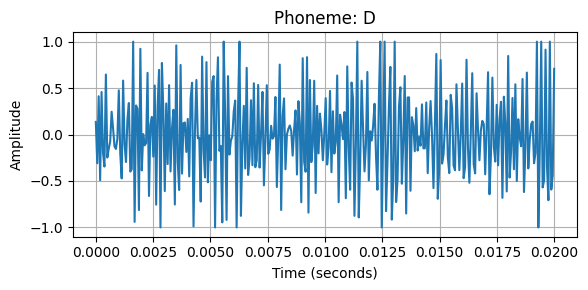

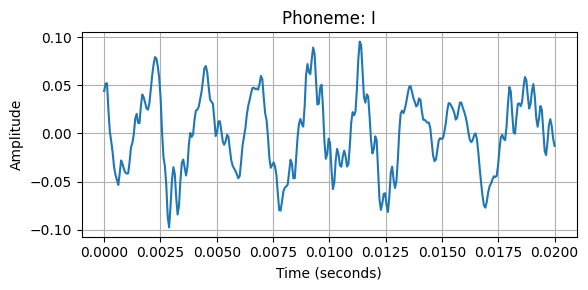

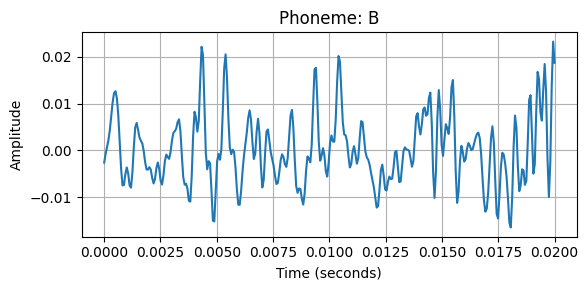

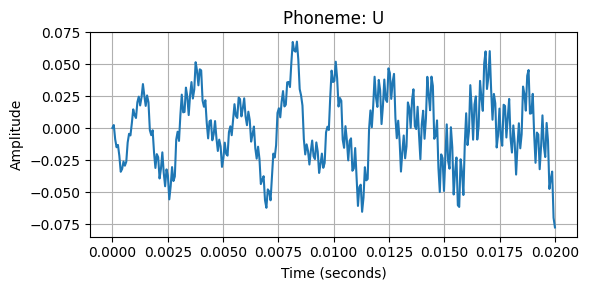

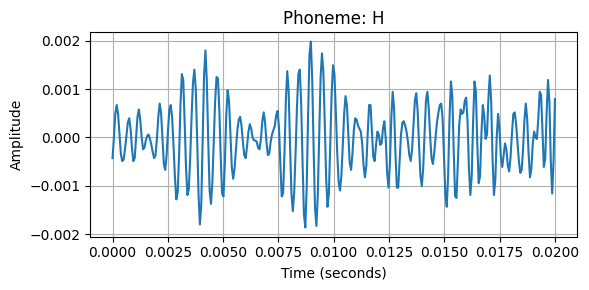

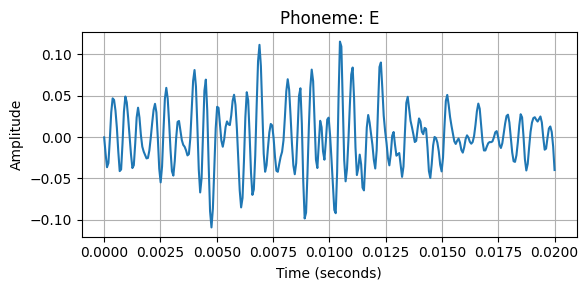

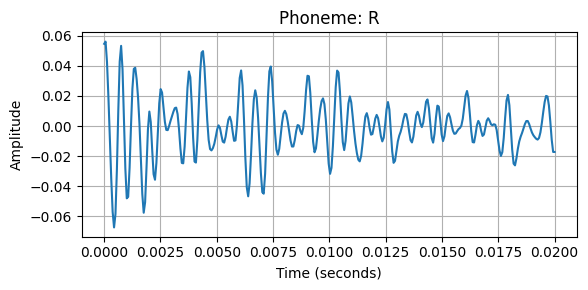

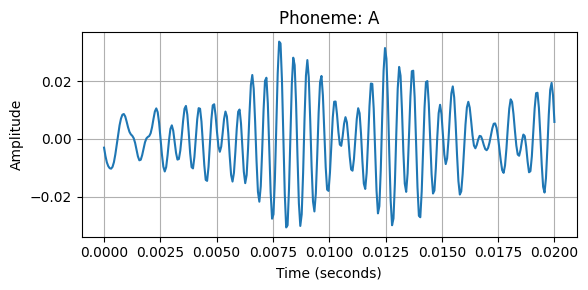

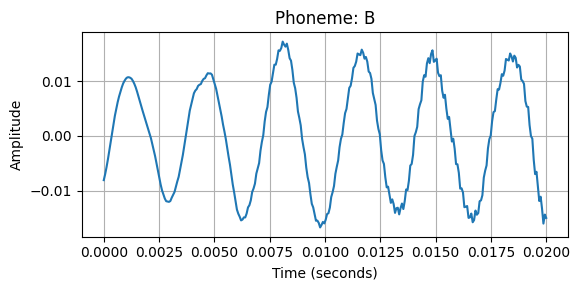

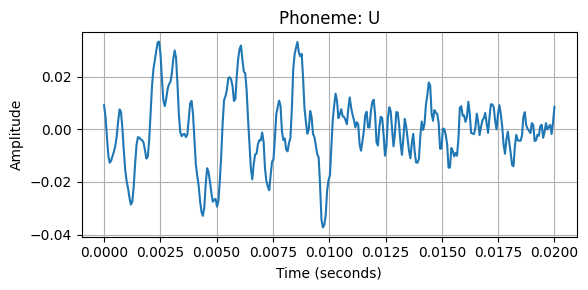

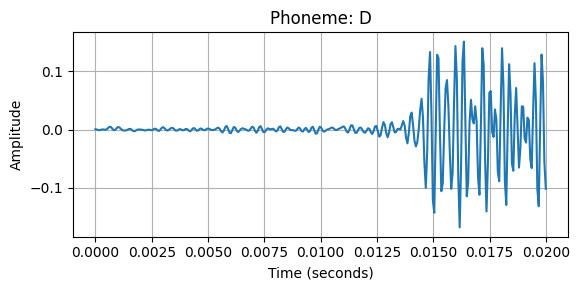

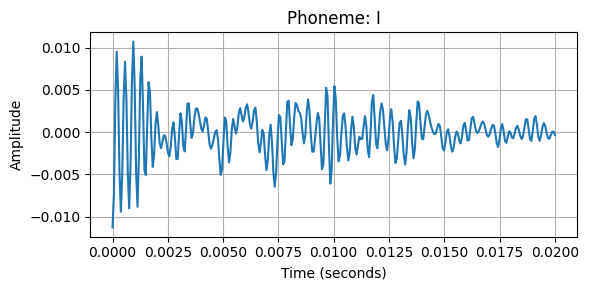

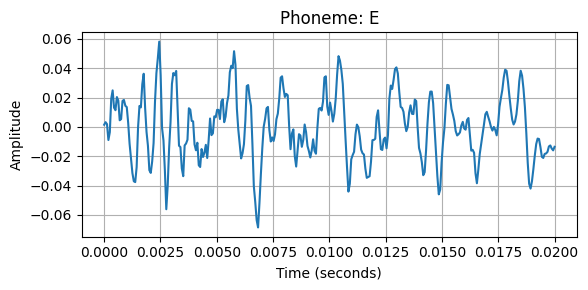

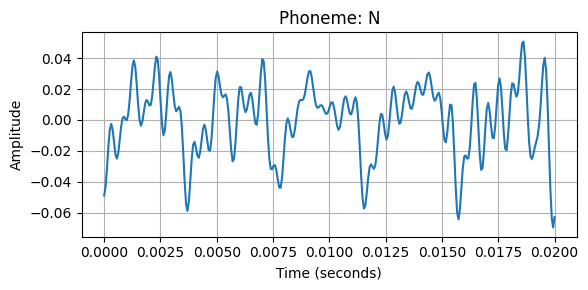

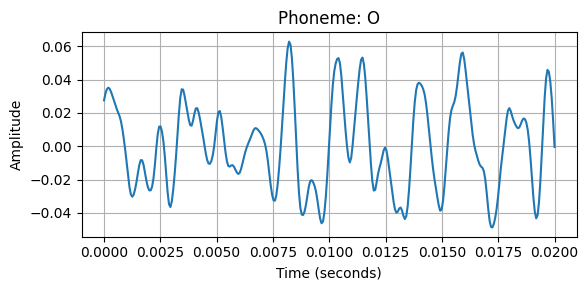

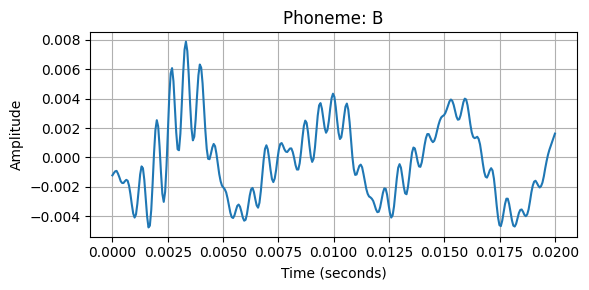

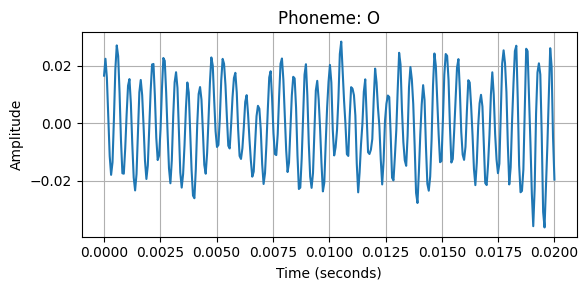

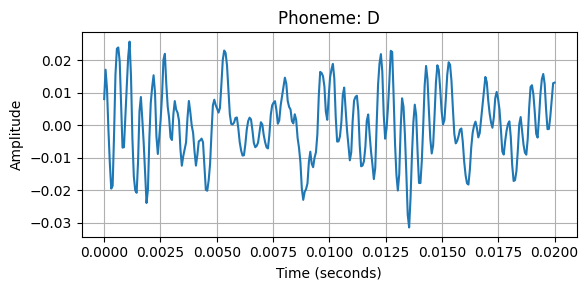

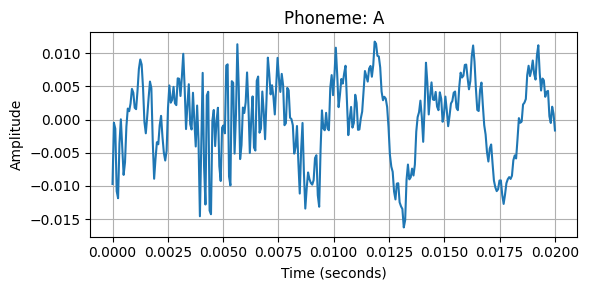

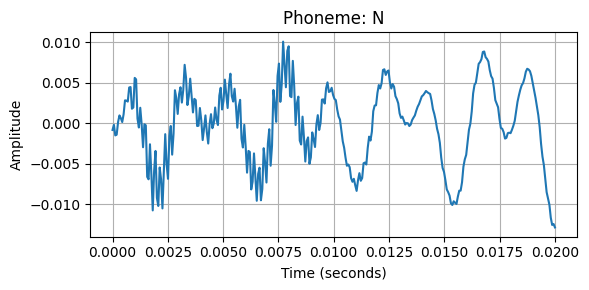

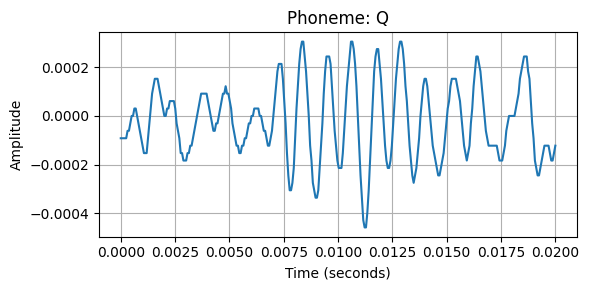

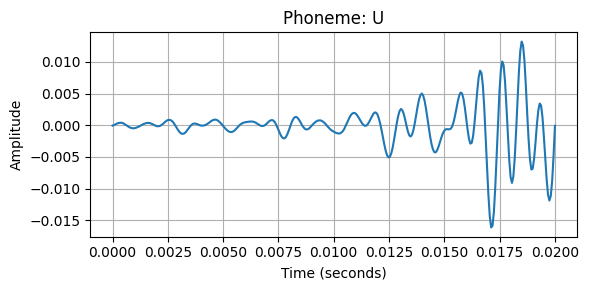

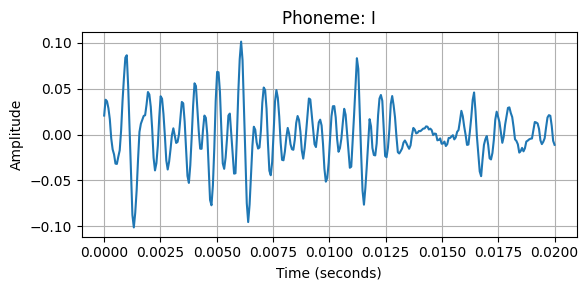

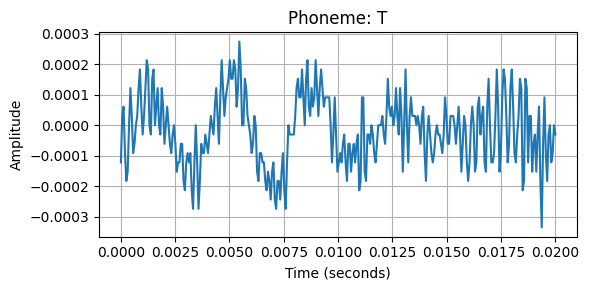

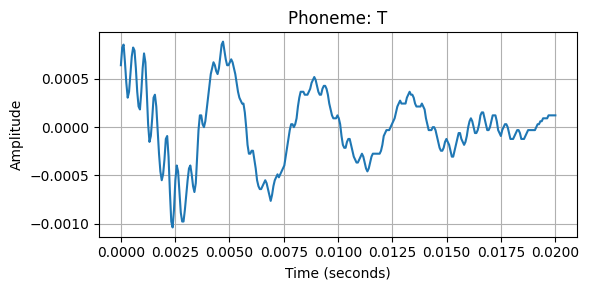

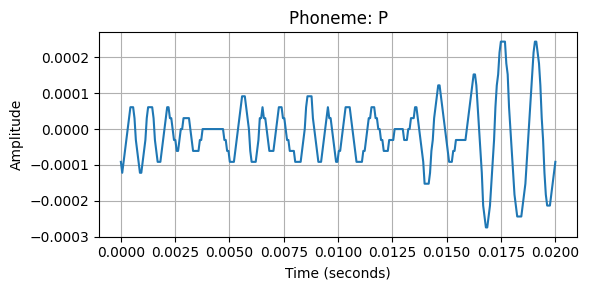

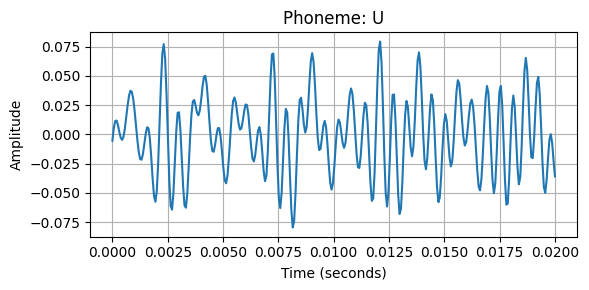

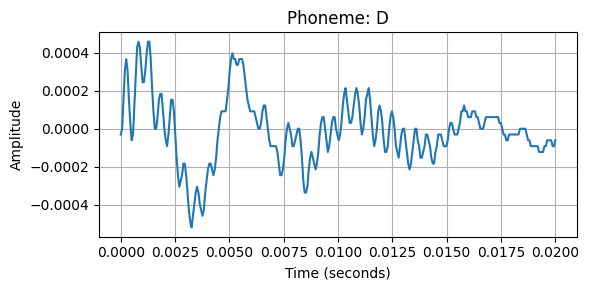

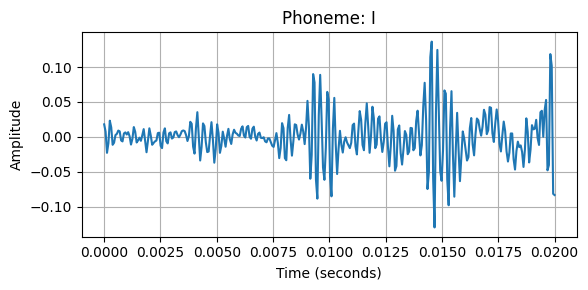

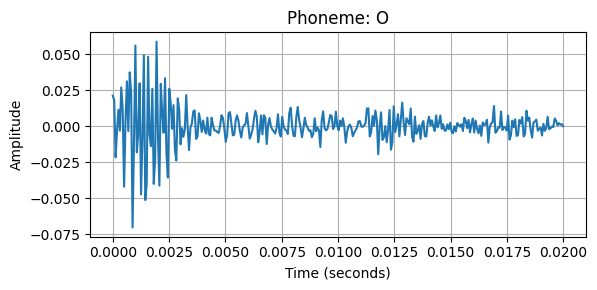

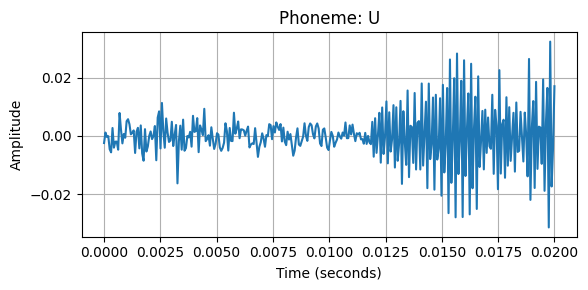

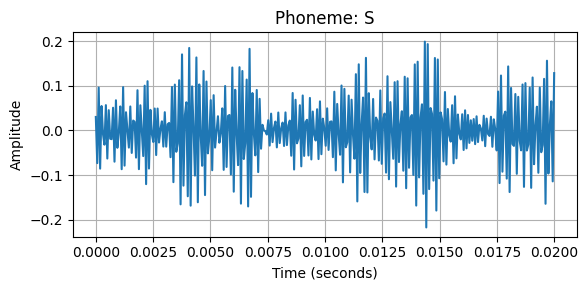

In [7]:
audio_path = "/content/drive/MyDrive/Colab Notebooks/Speech Processing/Lab3/preprocessed_speech.wav"
speech, sr = librosa.load(audio_path, sr=16000)

segments = []
with open("phoneme_segments.txt") as f:
    for line in f:
        p, s, e, d = line.strip().split(",")
        segments.append((p, float(s), float(e), float(d)))

print("Total phoneme segments:", len(segments))

for idx, (phoneme, start, end, duration) in enumerate(segments):

    start_sample = int(start * sr)
    end_sample   = int(end * sr)

    phoneme_signal = speech[start_sample:end_sample]

    if len(phoneme_signal) == 0:
        continue

    time_axis = np.linspace(0, duration, len(phoneme_signal))

    plt.figure(figsize=(6,3))
    plt.plot(time_axis, phoneme_signal)
    plt.title(f"Phoneme: {phoneme}")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


4. For every phoneme segment:
✓ Identify its phoneme category
(vowel, plosive, fricative, affricate, semivowel, diphthong, or whisper segment).
✓ Label the phoneme accordingly.

In [9]:
speech, sr = librosa.load("/content/drive/MyDrive/Colab Notebooks/Speech Processing/Lab3/preprocessed_speech.wav", sr=16000)

segments = []
with open("phoneme_segments.txt") as f:
    for line in f:
        p, s, e, d = line.strip().split(",")
        segments.append((p.strip(), float(s), float(e), float(d)))

phoneme_categories = {

# VOWELS
"AA":"Vowel","AE":"Vowel","AH":"Vowel","AO":"Vowel","EH":"Vowel",
"ER":"Vowel","IH":"Vowel","IY":"Vowel","UH":"Vowel","UW":"Vowel",

# DIPHTHONGS
"AW":"Diphthong","AY":"Diphthong","EY":"Diphthong","OW":"Diphthong","OY":"Diphthong",

# PLOSIVES
"P":"Plosive","B":"Plosive","T":"Plosive","D":"Plosive",
"K":"Plosive","G":"Plosive",

# FRICATIVES
"F":"Fricative","V":"Fricative","S":"Fricative","Z":"Fricative",
"SH":"Fricative","ZH":"Fricative","TH":"Fricative","DH":"Fricative",
"HH":"Fricative",

# AFFRICATES
"CH":"Affricate","JH":"Affricate",

# SEMIVOWELS
"L":"Semivowel","R":"Semivowel","W":"Semivowel","Y":"Semivowel",

# NASALS
"M":"Semivowel","N":"Semivowel","NG":"Semivowel"
}

def get_category(p):
    return phoneme_categories.get(p.upper(), "Whisper / Silence")

for i,(phoneme,start,end,duration) in enumerate(segments):

    start_sample = int(start*sr)
    end_sample   = int(end*sr)
    phoneme_signal = speech[start_sample:end_sample]

    if len(phoneme_signal)==0:
        continue

    category = get_category(phoneme)

    time_axis = np.linspace(0,duration,len(phoneme_signal))

    plt.figure(figsize=(6,3))
    plt.plot(time_axis, phoneme_signal)
    plt.title(f"Phoneme: {phoneme}   |   Category: {category}")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"{phoneme} --> {category}")


Output hidden; open in https://colab.research.google.com to view.

5. Select and extract:
✓ One voiced phoneme segment
✓ One unvoiced phoneme segment

Selected Voiced Phoneme: ('R', 1.762, 1.782, 0.02)
Selected Unvoiced Phoneme: ('S', 1.442, 1.462, 0.02)


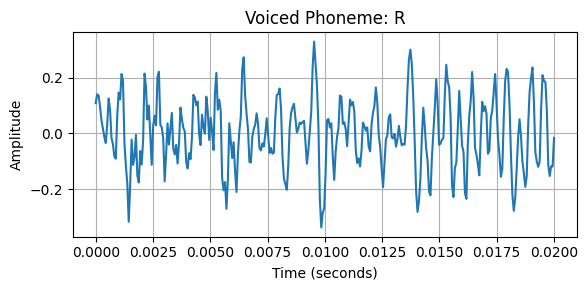

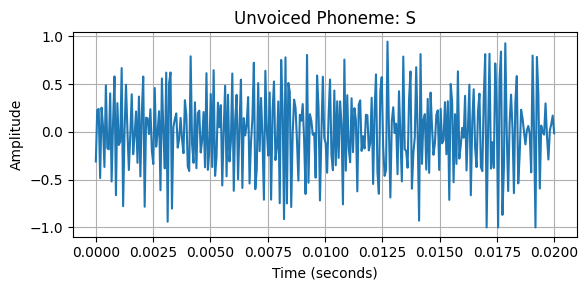

In [10]:
speech, sr = librosa.load("/content/drive/MyDrive/Colab Notebooks/Speech Processing/Lab3/preprocessed_speech.wav", sr=16000)

segments = []
with open("phoneme_segments.txt") as f:
    for line in f:
        p, s, e, d = line.strip().split(",")
        segments.append((p.strip(), float(s), float(e), float(d)))

voiced_phonemes = {
"AA","AE","AH","AO","EH","ER","IH","IY","UH","UW",
"AW","AY","EY","OW","OY",
"B","D","G","V","Z","ZH","DH","JH",
"M","N","NG","L","R","W","Y"
}

unvoiced_phonemes = {
"P","T","K","F","S","SH","TH","CH","HH"
}

voiced_seg = None
unvoiced_seg = None

for p,s,e,d in segments:
    p = p.upper()
    if voiced_seg is None and p in voiced_phonemes:
        voiced_seg = (p,s,e,d)
    if unvoiced_seg is None and p in unvoiced_phonemes:
        unvoiced_seg = (p,s,e,d)
    if voiced_seg and unvoiced_seg:
        break

print("Selected Voiced Phoneme:", voiced_seg)
print("Selected Unvoiced Phoneme:", unvoiced_seg)

def plot_segment(seg, title):
    p,s,e,d = seg
    sig = speech[int(s*sr):int(e*sr)]
    t = np.linspace(0,d,len(sig))
    plt.figure(figsize=(6,3))
    plt.plot(t,sig)
    plt.title(title)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.tight_layout()
    plt.show()

plot_segment(voiced_seg,
             f"Voiced Phoneme: {voiced_seg[0]}")

plot_segment(unvoiced_seg,
             f"Unvoiced Phoneme: {unvoiced_seg[0]}")


6. Compare the waveform characteristics of the voiced and unvoiced segments and explain the observed differences based on:

✓ Periodicity

✓ Amplitude patterns

✓ Presence or absence of noise-like structure

Comparison of Voiced and Unvoiced Phoneme Waveforms

After extracting one voiced phoneme segment and one unvoiced phoneme segment, their time-domain waveforms were analyzed and compared. The following observations were made:

1. Periodicity
- Voiced Segment

Shows clear periodic oscillations.

Repeating cycles correspond to vocal fold vibrations.

Indicates presence of a fundamental frequency (pitch).

- Unvoiced Segment

Does not show periodic pattern.

Waveform appears random and irregular.

No clear pitch structure.

Voiced sounds are produced with vibrating vocal cords, which create periodic excitation. Unvoiced sounds are generated by turbulent airflow without vocal cord vibration, leading to aperiodic signals.

2. Amplitude Patterns
- Voiced Segment

Generally higher amplitude.

Amplitude remains relatively stable over time.

Smooth envelope.

- Unvoiced Segment

Lower amplitude compared to voiced sounds.

Amplitude fluctuates rapidly.

Irregular envelope.


Vocal cord vibration produces stronger acoustic energy in voiced sounds, while unvoiced sounds rely on weaker turbulence noise.

3. Presence or Absence of Noise-Like Structure
- Voiced Segment

Smooth waveform.

Harmonic structure.

Low randomness.

- Unvoiced Segment

Appears noise-like.

Jagged waveform.

High randomness.

Voiced phonemes are quasi-periodic with harmonic content, whereas unvoiced phonemes resemble broadband noise.

Objective 2

i. Record the given sentence at a sampling rate of 16 kHz, mono WAV format. Load the recorded
speech signal.

In [12]:
import librosa

audio_path = "/content/drive/MyDrive/Colab Notebooks/Speech Processing/Lab3/record2.wav"

# Load as mono and resample to 16 kHz
signal, sr = librosa.load(audio_path, sr=16000, mono=True)

print("Sampling Rate:", sr)
print("Number of Samples:", len(signal))

#Save
import soundfile as sf

sf.write("/content/drive/MyDrive/Colab Notebooks/Speech Processing/Lab3/record2_16k_mono.wav",
         signal, sr)


Sampling Rate: 16000
Number of Samples: 60480


ii. Identify regions corresponding to fricatives and approximants.

Sampling Rate: 16000
Total Samples: 60480
Fricative frames detected: 50
Approximant frames detected: 326

First 10 Fricative Regions (sec)
(1.68, 1.705)
(1.69, 1.715)
(1.7, 1.725)
(1.71, 1.735)
(1.72, 1.745)
(1.73, 1.755)
(1.74, 1.765)
(1.75, 1.775)
(1.76, 1.785)
(1.77, 1.795)

First 10 Approximant Regions (sec)
(0.0, 0.025)
(0.01, 0.035)
(0.02, 0.045)
(0.03, 0.055)
(0.04, 0.065)
(0.05, 0.075)
(0.06, 0.085)
(0.07, 0.095)
(0.08, 0.105)
(0.09, 0.115)


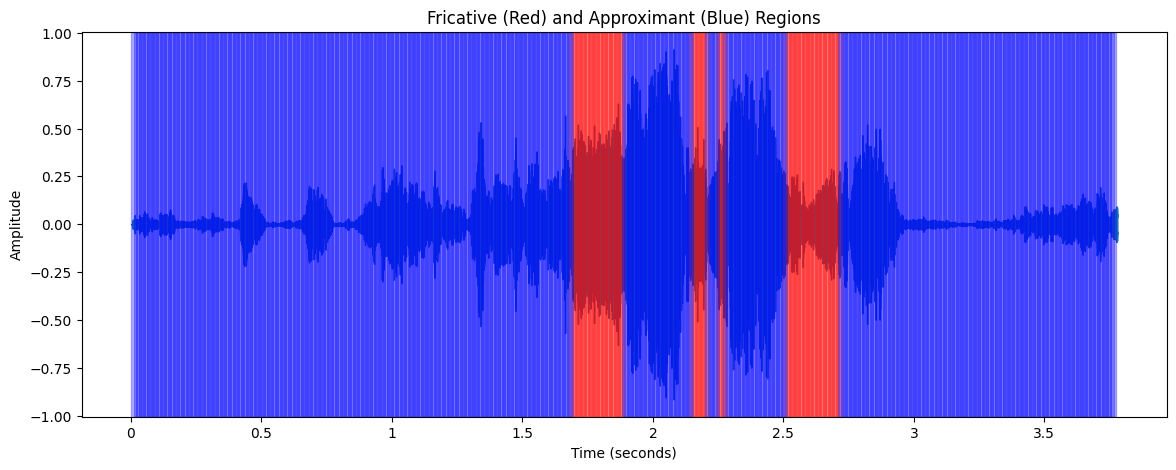

In [18]:
audio_path = "/content/drive/MyDrive/Colab Notebooks/Speech Processing/Lab3/record2_16k_mono.wav"
signal, sr = librosa.load(audio_path, sr=16000, mono=True)

print("Sampling Rate:", sr)
print("Total Samples:", len(signal))


# FRAME SETTINGS
frame_length = int(0.025 * sr)   # 25 ms
hop_length   = int(0.010 * sr)   # 10 ms


# FRAME SIGNAL
frames = librosa.util.frame(
    signal,
    frame_length=frame_length,
    hop_length=hop_length
)


# FREQUENCY BINS
freqs = np.fft.rfftfreq(frame_length, d=1/sr)
low_band  = np.where(freqs <= 1000)[0]
high_band = np.where((freqs >= 3000) & (freqs <= 8000))[0]


# CLASSIFICATION
fricative_frames = []
approximant_frames = []

for i in range(frames.shape[1]):

    frame = frames[:, i]
    spectrum = np.abs(np.fft.rfft(frame))

    low_energy  = np.sum(spectrum[low_band])
    high_energy = np.sum(spectrum[high_band])
    total_energy = np.sum(frame**2)

    if total_energy < 1e-4:
        continue

    if high_energy > low_energy:
        fricative_frames.append(i)
    else:
        approximant_frames.append(i)

print("Fricative frames detected:", len(fricative_frames))
print("Approximant frames detected:", len(approximant_frames))


# FRAME → TIME
def frame_to_time(frame_index):
    start = frame_index * hop_length / sr
    end   = (frame_index * hop_length + frame_length) / sr
    return start, end

fricative_regions   = [frame_to_time(f) for f in fricative_frames]
approximant_regions = [frame_to_time(f) for f in approximant_frames]


# PRINT SAMPLE REGIONS
print("\nFirst 10 Fricative Regions (sec)")
for r in fricative_regions[:10]:
    print(r)

print("\nFirst 10 Approximant Regions (sec)")
for r in approximant_regions[:10]:
    print(r)


# PLOT WITH COLOR HIGHLIGHT
plt.figure(figsize=(14,5))
librosa.display.waveshow(signal, sr=sr)
plt.title("Fricative (Red) and Approximant (Blue) Regions")

for s,e in fricative_regions:
    plt.axvspan(s, e, color='red', alpha=0.3)

for s,e in approximant_regions:
    plt.axvspan(s, e, color='blue', alpha=0.3)

plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()


iii. Use the segmentation approach to automatically extract phoneme-level segments.


In [20]:
audio_path = "/content/drive/MyDrive/Colab Notebooks/Speech Processing/Lab3/record2_16k_mono.wav"
speech, sr = librosa.load(audio_path, sr=16000)

print("Sampling Rate:", sr)
print("Audio Duration (sec):", len(speech)/sr)

processor = Wav2Vec2Processor.from_pretrained(
    "facebook/wav2vec2-base-960h"
)
model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-base-960h"
)

inputs = processor(
    speech,
    sampling_rate=16000,
    return_tensors="pt"
)

with torch.no_grad():
    logits = model(inputs.input_values).logits

predicted_ids = torch.argmax(logits, dim=-1)
tokens = processor.batch_decode(predicted_ids)

print("\nRecognized Phoneme/Character Sequence:\n")
print(tokens[0])

num_frames = logits.shape[1]
audio_duration = len(speech) / sr
time_per_frame = audio_duration / num_frames

ids = predicted_ids[0].tolist()
segments = []

prev_id = ids[0]
start_frame = 0

for i in range(1, len(ids)):
    if ids[i] != prev_id:
        phoneme = processor.tokenizer.decode([prev_id])
        start_time = start_frame * time_per_frame
        end_time = i * time_per_frame
        duration = end_time - start_time

        segments.append((phoneme, start_time, end_time, duration))

        prev_id = ids[i]
        start_frame = i

phoneme = processor.tokenizer.decode([prev_id])
start_time = start_frame * time_per_frame
end_time = num_frames * time_per_frame
duration = end_time - start_time
segments.append((phoneme, start_time, end_time, duration))

print("\nPHONEME-LEVEL SEGMENTATION WITH CONTINUATION\n")
print("Phoneme | Start(s) | End(s) | Duration(s)")
print("-------------------------------------------")

for p, s, e, d in segments:
    if p.strip() != "":
        print(f"{p:6s} | {s:7.3f} | {e:7.3f} | {d:7.3f}")

with open("phoneme_segments1.txt", "w") as f:
    for p, s, e, d in segments:
        if p.strip() != "":
            f.write(f"{p},{s:.3f},{e:.3f},{d:.3f}\n")

print("\nSaved to phoneme_segments1.txt")

Sampling Rate: 16000
Audio Duration (sec): 3.78


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Recognized Phoneme/Character Sequence:

WHY I A SHA SON

PHONEME-LEVEL SEGMENTATION WITH CONTINUATION

Phoneme | Start(s) | End(s) | Duration(s)
-------------------------------------------
W      |   0.945 |   0.965 |   0.020
H      |   0.965 |   0.985 |   0.020
Y      |   1.066 |   1.086 |   0.020
I      |   1.367 |   1.387 |   0.020
A      |   1.568 |   1.588 |   0.020
S      |   1.810 |   1.830 |   0.020
H      |   1.830 |   1.870 |   0.040
A      |   1.991 |   2.011 |   0.020
S      |   2.232 |   2.252 |   0.020
O      |   2.795 |   2.815 |   0.020
N      |   2.815 |   2.835 |   0.020

Saved to phoneme_segments1.txt


iv. Isolate segments corresponding to fricatives (/s/, /ʃ/, /z/) and approximants (/j/).

v. Plot the waveform of each extracted fricative and approximant segment.

Total segments: 11
Fricative segments found: 2
Approximant segments found: 1


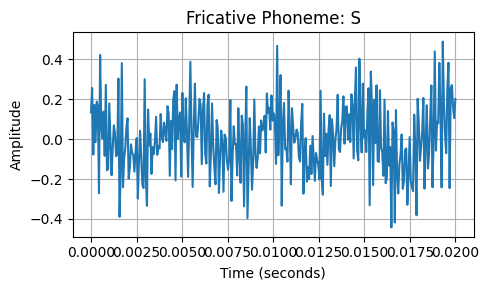

Saved: Fricative_S_0.wav


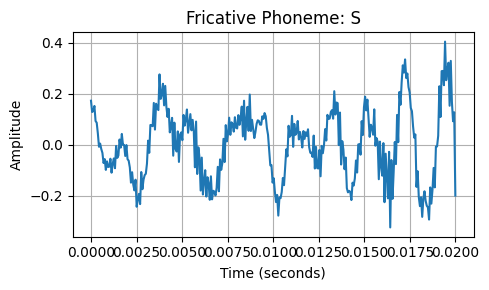

Saved: Fricative_S_1.wav


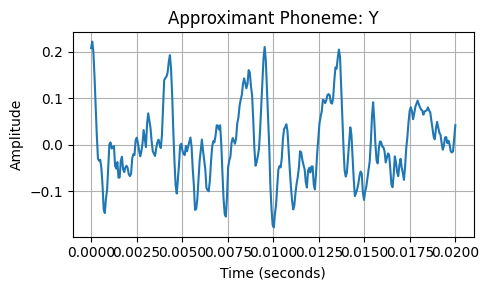

Saved: Approximant_Y_0.wav


In [22]:
speech, sr = librosa.load("/content/drive/MyDrive/Colab Notebooks/Speech Processing/Lab3/record2_16k_mono.wav", sr=16000)


# LOAD PHONEME SEGMENTS
segments = []
with open("phoneme_segments1.txt") as f:
    for line in f:
        p, s, e, d = line.strip().split(",")
        segments.append((p.strip().upper(), float(s), float(e), float(d)))

print("Total segments:", len(segments))


# TARGET PHONEMES
fricatives = {"S", "SH", "Z"}   # /s/, /ʃ/, /z/
approximants = {"Y"}           # /j/

fricative_segments = []
approximant_segments = []

for p, s, e, d in segments:
    if p in fricatives:
        fricative_segments.append((p, s, e, d))
    elif p in approximants:
        approximant_segments.append((p, s, e, d))

print("Fricative segments found:", len(fricative_segments))
print("Approximant segments found:", len(approximant_segments))

def process_segments(segment_list, label):

    for i, (p, s, e, d) in enumerate(segment_list):

        seg_signal = speech[int(s*sr):int(e*sr)]
        filename = f"{label}_{p}_{i}.wav"
        sf.write(filename, seg_signal, sr)

        t = np.linspace(0, d, len(seg_signal))

        plt.figure(figsize=(5,3))
        plt.plot(t, seg_signal)
        plt.title(f"{label} Phoneme: {p}")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Amplitude")
        plt.grid()
        plt.tight_layout()
        plt.show()

        print("Saved:", filename)


# PROCESS FRICATIVES
process_segments(fricative_segments, "Fricative")


# PROCESS APPROXIMANTS
process_segments(approximant_segments, "Approximant")


vi. Observe qualitative differences in waveform smoothness, amplitude continuity, presence of noise-like fluctuations.

1. Waveform Smoothness

The fricative waveforms are rough and jagged.

No smooth sinusoidal pattern is visible.

Rapid sample-to-sample variations exist.

➡ This indicates aperiodic behavior.

2. Amplitude Continuity

The amplitude envelope is irregular.

Sudden increases and decreases in amplitude occur.

No stable repeating amplitude pattern.

➡ Indicates unstable airflow excitation.

3. Presence of Noise-Like Fluctuations

Strong noise-like texture is visible.

Signal resembles random noise rather than harmonic oscillations.

No clear pitch structure.

➡ Confirms noise-dominated sound production.

Interpretation in Terms of Airflow Type
- Fricatives

Air passes through a narrow constriction in the vocal tract.

High air velocity + narrow opening → Turbulent airflow.

Turbulence corresponds to high effective Reynolds number.

- Fricatives → Turbulent airflow

- Approximants (Conceptual, even though none detected)

Vocal tract is more open.

Airflow moves smoothly.

Lower air velocity variations.

- Approximants → Smooth / Laminar airflow
→ Lower effective Reynolds number.

vii. Based on waveform observations, infer conceptually whether the airflow is turbulent (associated with higher effective Reynolds number) or Smooth/laminar (associated with lower effective Reynolds number).


Property	        |   Fricatives	          |   Approximants

Waveform shape   	|   Irregular	            |   Smooth

Periodicity	      |   Absent	              |   Present (quasi-periodic)

Noise content	    |   High	                |   Low

Energy variation  |	 Rapid fluctuations	    |   Gradual changes

Pitch structure   |	 Absent                 | 	Present

Airflow type	    |  Turbulent              |  	Laminar

viii. Compare fricatives and approximants in terms of waveform irregularity, periodicity, energy variation. Relate the observations to articulatory constriction differences.

- Fricatives

Tight constriction between articulators (tongue–teeth, tongue–alveolar ridge).

Produces jet of air.

Jet becomes unstable → turbulence.

Causes noisy waveform.

- Approximants

Wider constriction.

Vocal tract behaves like a resonant tube.

Vocal fold vibration dominates.

Produces smooth waveform.

The extracted fricative segments exhibit irregular, noise-like waveforms with rapid amplitude fluctuations and absence of periodicity, indicating turbulent airflow associated with high Reynolds number due to narrow articulatory constriction. In contrast, approximant sounds (conceptually) exhibit smooth, quasi-periodic waveforms with gradual amplitude variations, indicating laminar airflow and wider articulatory constriction.